Step 1: Install Required Libraries

In [1]:
!pip install imbalanced-learn joblib

Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

Step 3: Load and Inspect Dataset

In [3]:
# Load dataset
df = pd.read_csv('/content/CESAW_Task_fact.csv')

# Display dataset overview
print("Dataset Preview:")
print(df.head())


Dataset Preview:
    task_id            task_type  task_complexity  task_priority  \
0  f0f9c6bc           Bug Fixing                1              1   
1  a96b4054              Testing                3              3   
2  3abad251  Feature Development                1              3   
3  46b79443  Feature Development                2              3   
4  59fed919           Bug Fixing                1              3   

   estimated_effort_hours  team_experience_level  total_members  \
0                   39.67                      3             13   
1                   29.30                      3              7   
2                   48.97                      3              9   
3                   41.25                      2              8   
4                   36.19                      2             11   

   past_projects_completed          specialization  team_skillset_match  \
0                        4  Mobile App Development                67.19   
1                    

Step 4: Encode Categorical Variables

Since the target variable (assigned_team) is categorical, it needs to be converted to numerical labels before training.

In [4]:
# Initialize label encoder for target variable
label_encoder = LabelEncoder()
df['assigned_team'] = label_encoder.fit_transform(df['assigned_team'])

print("\nCategorical Target Variable Encoded Successfully.")


Categorical Target Variable Encoded Successfully.


Step 5: Define Features and Target Variable

The dataset is split into independent features (X) and the target variable (y).

In [5]:
# Define features and target variable
X = df.drop(['task_id', 'assigned_team', 'team_skillset_match', 'team_availability', 'total_members'], axis=1)
y = df['assigned_team']

print(f"\nFeature Selection Completed: {X.shape[1]} features selected.")


Feature Selection Completed: 7 features selected.


Step 6: Split Dataset into Training & Testing Sets

We divide the dataset into 80% training and 20% testing to validate model performance.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData Split: {X_train.shape[0]} training rows, {X_test.shape[0]} testing rows.")


Data Split: 400 training rows, 100 testing rows.


Step 7: Preprocess Features (Numerical & Categorical)

Feature scaling ensures numerical stability, while one-hot encoding handles categorical features.

In [7]:
# Define categorical and numerical feature lists
categorical_features = ['task_type', 'specialization']
numerical_features = ['task_complexity', 'task_priority', 'estimated_effort_hours',
                      'team_experience_level', 'past_projects_completed']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("\nFeature Preprocessing Pipeline Defined.")


Feature Preprocessing Pipeline Defined.


Step 8: Define the Model

The RandomForestClassifier is chosen as the main model due to its ability to handle complex feature interactions.

In [8]:
# Initialize Random Forest model
model = RandomForestClassifier(random_state=42)

print("\nRandom Forest Classifier Initialized.")


Random Forest Classifier Initialized.


Step 9: Create a Training Pipeline with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is used to balance the dataset so that all teams have sufficient training data.

In [9]:
# Create pipeline with SMOTE to handle class imbalance
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

print("\nPipeline with SMOTE Created Successfully.")


Pipeline with SMOTE Created Successfully.


Step 10: Hyperparameter Tuning Using GridSearchCV

Instead of training with default parameters, we search for the best model settings.

In [10]:
# Define hyperparameter grid for tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_pipeline = grid_search.best_estimator_

print(f"\nBest Model Parameters: {grid_search.best_params_}")



Best Model Parameters: {'model__bootstrap': True, 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


Step 11: Cross-Validation with Best Model

To ensure the best model generalizes well, we evaluate it using cross-validation.

In [11]:
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='accuracy')

print(f'\nCross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {np.mean(cv_scores):.4f}')


Cross-validation accuracy scores: [0.7    0.7875 0.7625 0.7375 0.825 ]
Mean cross-validation accuracy: 0.7625


Step 12: Train the Final Model

We now train the best model on the entire training dataset.

In [12]:
best_pipeline.fit(X_train, y_train)

print("\nFinal Model Training Completed.")


Final Model Training Completed.


Step 13: Make Predictions

We now use the trained model to predict task allocation for the test data.

In [13]:
y_pred = best_pipeline.predict(X_test)

print("\nPredictions Generated.")


Predictions Generated.


Step 14: Evaluate Model Performance

We assess accuracy, classification report, and confusion matrix.

In [14]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report and confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Print evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(conf_matrix)



Test Accuracy: 0.7600

Classification Report:
              precision    recall  f1-score   support

          T1       0.70      0.88      0.78         8
         T10       0.82      0.69      0.75        13
          T2       0.83      0.62      0.71         8
          T3       0.70      0.88      0.78         8
          T4       1.00      0.91      0.95        11
          T5       0.58      0.70      0.64        10
          T6       0.82      0.90      0.86        10
          T7       0.71      0.80      0.75        15
          T8       0.67      0.67      0.67         6
          T9       0.86      0.55      0.67        11

    accuracy                           0.76       100
   macro avg       0.77      0.76      0.75       100
weighted avg       0.78      0.76      0.76       100


Confusion Matrix:
[[ 7  0  0  0  0  0  1  0  0  0]
 [ 0  9  1  1  0  0  0  2  0  0]
 [ 0  0  5  1  0  1  1  0  0  0]
 [ 0  0  0  7  0  1  0  0  0  0]
 [ 1  0  0  0 10  0  0  0  0  0]
 [ 1  0  0

Step 15: Save the Model

The trained model is saved for future use in the API.

In [15]:
joblib.dump(best_pipeline, 'task_allocation_model.pkl')

print("\nModel Saved Successfully.")


Model Saved Successfully.


Step 16: Save Accuracy Metrics

To track model performance, we store accuracy metrics separately.

In [16]:
accuracy_metrics = {
    'cross_validation_scores': cv_scores,
    'mean_cross_validation_accuracy': np.mean(cv_scores),
    'test_accuracy': accuracy,
    'classification_report': class_report
}

joblib.dump(accuracy_metrics, 'accuracy_metrics.pkl')

print("\nAccuracy Metrics Saved.")


Accuracy Metrics Saved.


Step 17: Save Feature Importance

Feature importance shows which features contributed the most to predictions.

In [17]:
feature_importances = best_pipeline.named_steps['model'].feature_importances_
feature_names = numerical_features + list(best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

feature_importance_dict = dict(zip(feature_names, feature_importances))
joblib.dump(feature_importance_dict, 'feature_importance.pkl')

print("\nFeature Importance Scores Saved.")


Feature Importance Scores Saved.


Step 18: Visualize Accuracy Metrics

Now, let's plot the cross-validation accuracy scores to see how well the model performs across different folds.

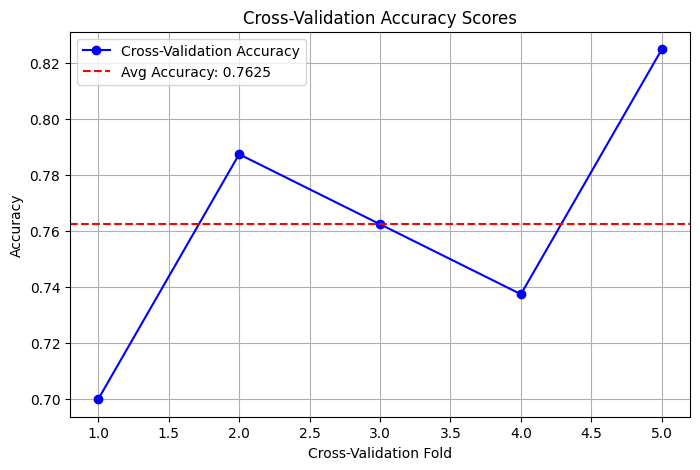


Cross-validation accuracy plot displayed.


In [18]:
import matplotlib.pyplot as plt

# Plot cross-validation scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='b', label='Cross-Validation Accuracy')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Avg Accuracy: {np.mean(cv_scores):.4f}')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.legend()
plt.grid(True)
plt.show()

print("\nCross-validation accuracy plot displayed.")
